# WGAN-GP crear datos sintéticos

In [23]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import os
import json

import tensorflow as tf
from tensorflow.keras import (
    layers,
    models,
    callbacks,
    losses,
    utils,
    metrics,
    optimizers,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 0. Establecer parámetros <a name="Parámetros"></a>

In [24]:
IMAGE_SIZE = 32
CHANNELS = 1
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0002
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 1000#200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

## 1. Cargar los datos <a name="Preparar"></a>

In [25]:
# Cargar el archivo .npy
malware_data = np.load("./data/dataset_malware.npy")

# Revisamos normalización
print("Shape del dataset:", malware_data.shape)
print("Min:", malware_data.min(), "Max:", malware_data.max())

Shape del dataset: (584, 32, 32, 1)
Min: -1.0 Max: 1.0


In [26]:
# Creamos un dataset de TensorFlow

# Creamos un objeto Dataset a partir del tensor en malware_data
train_data = tf.data.Dataset.from_tensor_slices(malware_data) 

# Mezclamos aleatoriamente los elementos del Dataset.
train_data = train_data.shuffle(buffer_size=malware_data.shape[0], seed=42) 

# Agrupamos los datos en lotes (batches) del tamaño BATCH_SIZE. 
# prefetch prepara, durante el entrenamiento, el siguiente batch (al usar AUTOTUNE se da al sistema elegir cuantos preparar según los recursos del sistema) 
train_data = train_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) 
train = train_data

### 1.1 Cargar los modelos <a name="Preparar"></a>

In [27]:
from tensorflow.keras.models import load_model

# Cargar los modelos
generator = load_model("./models/generator.keras")
critic = load_model("./models/critic.keras")

## 2. Generar nuevas imágenes <a name="decode"></a>

In [28]:
# Muestrea algunos puntos del espacio latente con distribución normal estándar (noise)
grid_width, grid_height = (5, 3)
# Lote de vectores
z_sample = np.random.normal(size=(grid_width * grid_height, Z_DIM))
# Pasa el lote de vectores por la GAN.
gen_imgs = generator.predict(z_sample) # Reconstrucción. Arreglo NumPy.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step


### 2.1 Funciones de decodificación <a name="s"></a>

In [29]:
import numpy as np
import time
from datetime import datetime

def extraer_funciones_desde_txt(txt_path="./Extraer_Caracteristicas/funciones_existentes.txt"):
    with open(txt_path, "r") as f:
        lista_funciones = [linea.strip() for linea in f]  # .strip() quita el salto de línea.
    return lista_funciones

# === Deben coincidir con tu encoder ===
NORMALIZAR_ENTRADA = "0-1"  # o "menos1-a-1"
FUNCIONES_API = extraer_funciones_desde_txt(txt_path="./data/funciones_existentes.txt")  # tu misma lista (lib::func)
N = len(FUNCIONES_API)

# Orden exacto que usaste al codificar
FAMILIAS = [
    "benign", "_Action", "_Chthonic", "_Citadel", "_Evo-Zeus (Evolution)", "_Flokibot",
    "_Grabbot", "_Ice IX", "_KINS", "_Murofet", "_Pandabanker", "_PowerZeus",
    "_Prog", "_Satan", "_Skynet", "_Tasks", "_Uncategorized",
    "_Unnamed 1", "_Unnamed 10", "_Unnamed 2", "_Unnamed 3", "_Unnamed 4",
    "_Unnamed 7", "_Unnamed 8", "_Unnamed 9", "_VMZeus", "_ZeuS 1",
    "_ZeuS 2", "_ZeuS v4 (Unnamed 5)", "_Zeus z2.5 (Unnamed 6)",
    "_ZeusAES", "_ZeusX", "_Zloader 2 (Silent Night)", "_Zloader",
    "ZeuS Over Tor (Sphinx)", "ZeuS-P2P (GameOver)"
]
FAMILIAS_ORD = sorted(FAMILIAS)
NUM_FAMS = len(FAMILIAS_ORD)

# Constantes de normalización que usaste
TS_MIN = 1104537600  # 2005-01-01
TS_MAX = 1893456000  # 2030-01-01
SECT_ENT_MIN, SECT_ENT_MAX = 0.0, 8.0
SECT_SIZE_MIN, SECT_SIZE_MAX = 0.0, 1_000_000.0
ENTROPY_MIN, ENTROPY_MAX = 0.0, 8.0
FSIZE_MIN, FSIZE_MAX = 0.0, 50*1024*1024  # 50 MB en bytes

# Vector de "datos" = 4 (cabecera) + 12 (4 secciones * 3) + 3 (sección extra) = 19
LEN_DATOS = 19  # [fam, size, timestamp, entropy] + 4*3 + 3

def desnormalizar(x, min_val, max_val):
    """
    Inversa de normalizar(). Si NORMALIZAR_ENTRADA == 'menos1-a-1',
    primero llevamos x de [-1,1] a [0,1].
    """
    if NORMALIZAR_ENTRADA == "menos1-a-1":
        x = (x + 1) / 2.0
    # ahora x en [0,1]
    return x * (max_val - min_val) + min_val

def imagen_a_vector(img):
    """
    Inversa de vector_a_imagen:
    - img viene en [-1,1] (salida GAN).
    - Lo llevamos a [0,1] y achatamos.
    """
    # deshacer: imagen = (vector * 2) - 1
    vec01 = (img + 1.0) / 2.0
    return vec01.flatten().astype(np.float32)

def vector_a_json(vec01):
    """
    vec01 es el vector completo en [0,1] (ya convertido desde [-1,1]).
    Estructura esperada: primeros LEN_DATOS = cabecera+secciones; resto = imports binarios sobre FUNCIONES_API.
    """
    # Cortes de seguridad
    expected_len = LEN_DATOS + N
    if len(vec01) < expected_len:
        # Si la GAN recortó, hacemos padding a 0
        vec01 = np.pad(vec01, (0, expected_len - len(vec01)))
    elif len(vec01) > expected_len:
        vec01 = vec01[:expected_len]

    datos = vec01[:LEN_DATOS]
    imports_vec = vec01[LEN_DATOS:LEN_DATOS+N]

    # ---- 1) Cabecera ----
    fam_norm, fsize_norm, ts_norm, ent_norm = datos[:4]

    # familia (usa fórmula del encoder: (idx*2+1)/(2*NUM_FAMS))
    # Inversa aproximada:
    fam_cont = fam_norm * 2 * NUM_FAMS - 1
    fam_idx = int(round(fam_cont / 2))
    fam_idx = max(0, min(NUM_FAMS - 1, fam_idx))
    software_family = FAMILIAS_ORD[fam_idx]

    # tamaño bytes
    file_size_bytes = desnormalizar(fsize_norm, FSIZE_MIN, FSIZE_MAX)
    # podemos expresar en KB redondeado
    file_size_kb = int(round(file_size_bytes / 1024.0))
    file_size_str = f"{file_size_kb}KB"

    # timestamp
    ts_val = desnormalizar(ts_norm, TS_MIN, TS_MAX)
    ts_val = max(TS_MIN, min(TS_MAX, ts_val))
    # A string estilo: "%a %b %d %H:%M:%S %Y\n"
    dt = time.localtime(int(ts_val))
    compilation_timestamp = time.strftime("%a %b %d %H:%M:%S %Y\n", dt)

    # entropía global
    entropy = float(desnormalizar(ent_norm, ENTROPY_MIN, ENTROPY_MAX))

    # ---- 2) Secciones ----
    # Orden codificado
    orden_secciones = [".text", ".idata", ".rsrc", ".data"]
    # Cada una tiene [ent, v_size, r_size] en ese orden
    sec_vals = datos[4:4 + 12]  # 4 secciones * 3 valores
    extra_vals = datos[16:19]   # sección adicional (3 valores)

    sections = []
    # 4 secciones fijas
    for i, name in enumerate(orden_secciones):
        ent_i = float(desnormalizar(sec_vals[i*3 + 0], SECT_ENT_MIN, SECT_ENT_MAX))
        vsz_i = int(round(desnormalizar(sec_vals[i*3 + 1], SECT_SIZE_MIN, SECT_SIZE_MAX)))
        rsz_i = int(round(desnormalizar(sec_vals[i*3 + 2], SECT_SIZE_MIN, SECT_SIZE_MAX)))
        sections.append({
            "name": name,
            "virtual_size": vsz_i,
            "raw_size": rsz_i,
            "entropy": ent_i,
            "entropy_block": []  # no lo codificaste; dejar vacío
        })

    # Sección adicional (la de mayor entropía fuera de las 4), solo si aporta algo
    ent_e = float(desnormalizar(extra_vals[0], SECT_ENT_MIN, SECT_ENT_MAX))
    vsz_e = int(round(desnormalizar(extra_vals[1], SECT_SIZE_MIN, SECT_SIZE_MAX)))
    rsz_e = int(round(desnormalizar(extra_vals[2], SECT_SIZE_MIN, SECT_SIZE_MAX)))
    if (ent_e > 0.0) or (vsz_e > 0) or (rsz_e > 0):
        sections.append({
            "name": ".extra_high_entropy",
            "virtual_size": vsz_e,
            "raw_size": rsz_e,
            "entropy": ent_e,
            "entropy_block": []
        })

    # ---- 3) Imports ----
    # Tu encoder binariza (0/1) y, si NORMALIZAR_ENTRADA == "menos1-a-1", mapea a {-1,1}.
    # Aquí recuperamos presencia usando umbral 0.5 (si 0-1) o 0 (si -1 a 1 sobre la imagen ya convertida a [0,1]).
    if NORMALIZAR_ENTRADA == "0-1":
        presencias = imports_vec >= 0.5
    else:
        # Recordatorio: ya convertimos la imagen a [0,1]. En ese esquema,
        # el 0 binario original -> 0.0 ; el 1 binario original -> 1.0 (tras tu normalización y mi deshacer)
        # Así que también sirve 0.5 como umbral.
        presencias = imports_vec >= 0.5

    presentes = [FUNCIONES_API[i] for i, ok in enumerate(presencias) if ok]

    # Reconstruimos "dlls": agrupando por libname
    dll_map = {}
    for full in presentes:
        # full = "lib::func"
        if "::" in full:
            lib, fn = full.split("::", 1)
        else:
            lib, fn = "unknown.dll", full
        # Re-ensamblar lib en formato "LIB.dll" similar a tus JSONs (opcional)
        lib_up = lib
        dll_map.setdefault(lib_up, []).append(fn)

    imports = {
        "dlls": [{"libname": lib, "functions": fns} for lib, fns in dll_map.items()],
        "suspicious_imports": {}  # no codificado
    }

    # ---- Armar JSON ----
    decoded = {
        "file_info": {
            "file_name": "",  # no codificado
            "software_family": software_family,
            "file_size": file_size_str,
            "hashes": {
                "md5": "",
                "sha256": ""
            }
        },
        "analysis": {
            "compilation_timestamp": compilation_timestamp,
            "entropy": entropy,
            "imports": imports,
            "strings": {
                "total_strings": 0,
                "detalles": [],
                "suspicious_strings": []
            },
            "sections": sections,
            "resources": {
                "total_size": 0,
                "details": []
            }
        }
    }
    return decoded

# === Uso típico ===
# img: numpy array (H,W) o (H,W,1) en rango [-1,1] salida de la GAN
# vec01 = imagen_a_vector(img)        # pasa a [0,1] y aplana
# json_out = vector_a_json(vec01)     # reconstrucción "lo que sí estaba codificado"


### 2.2 Mostrar imágenes generadas <a name="s"></a>

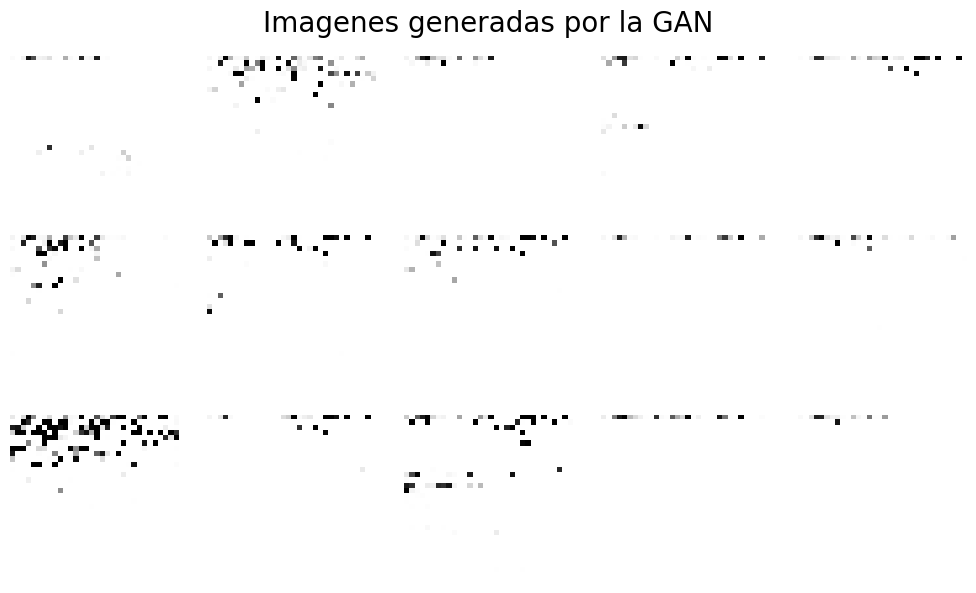

In [30]:
# Muestra las imagenes decodificadas (gen_imgs).
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
fig.suptitle("Imagenes generadas por la GAN", fontsize=20)


for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(gen_imgs[i, :, :], cmap="gray_r", vmin=-1, vmax=1)
plt.tight_layout()
plt.show()


### 2.3 Ejemplo: Reconstruir JSON a partir de imagen <a name="s"></a>

In [31]:
# Tomamos la primera imagen generada
img = gen_imgs[0]  

# Paso 1: convertir imagen [-1,1] a vector [0,1]
vec01 = imagen_a_vector(img)

# Paso 2: decodificar el vector a JSON
json_out = vector_a_json(vec01)

# Mostrar el JSON reconstruido
import json
print(json.dumps(json_out, indent=2))

{
  "file_info": {
    "file_name": "",
    "software_family": "ZeuS Over Tor (Sphinx)",
    "file_size": "61KB",
    "hashes": {
      "md5": "",
      "sha256": ""
    }
  },
  "analysis": {
    "compilation_timestamp": "Sat Jul 08 17:25:52 2006\n",
    "entropy": 7.36932373046875,
    "imports": {
      "dlls": [
        {
          "libname": "ntdll.dll",
          "functions": [
            "RtlGetSaclSecurityDescriptor"
          ]
        }
      ],
      "suspicious_imports": {}
    },
    "strings": {
      "total_strings": 0,
      "detalles": [],
      "suspicious_strings": []
    },
    "sections": [
      {
        "name": ".text",
        "virtual_size": 52040,
        "raw_size": 68923,
        "entropy": 5.58326530456543,
        "entropy_block": []
      },
      {
        "name": ".idata",
        "virtual_size": 5193,
        "raw_size": 447,
        "entropy": 1.0412228107452393,
        "entropy_block": []
      },
      {
        "name": ".rsrc",
        "virtual_

#### Reconstruir JSON a partir de imagen <a name="s"></a>

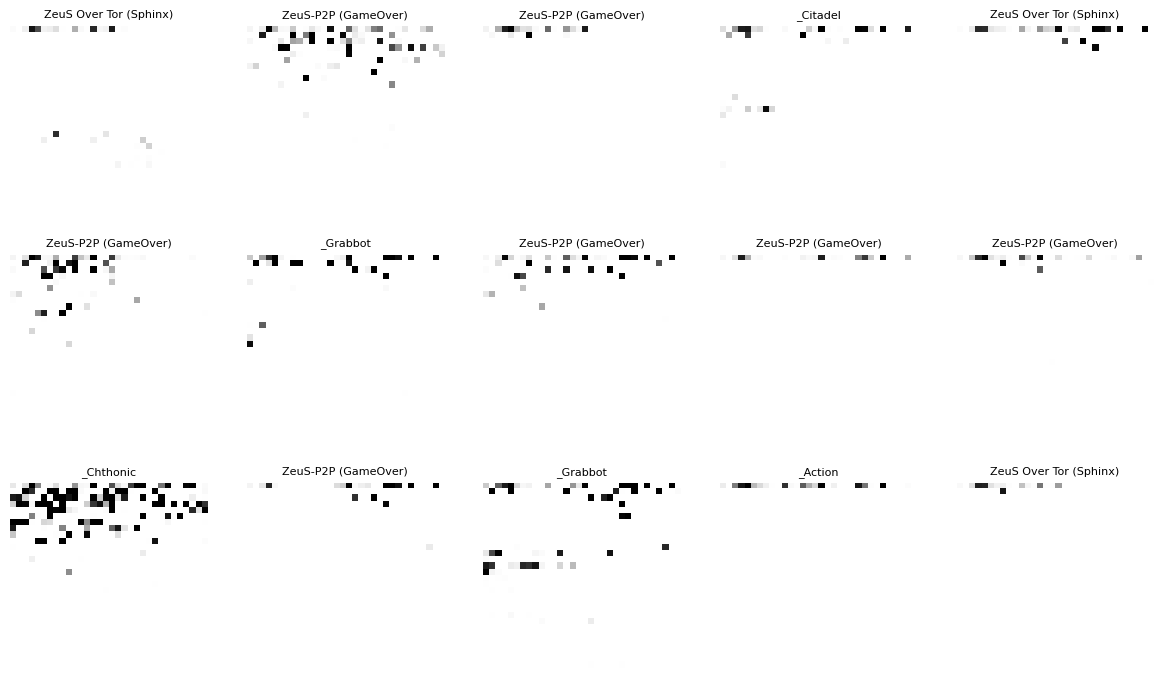

In [32]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(12, 7))

cnt = 0
for i in range(r):
    for j in range(c):
        img = gen_imgs[cnt]

        # Mostrar imagen
        axs[i, j].imshow(img, cmap="gray_r", vmin=-1, vmax=1)
        axs[i, j].axis("off")

        # Decodificar a JSON
        vec01 = imagen_a_vector(img)
        json_out = vector_a_json(vec01)

        # Mostrar la familia como título
        fam = json_out["file_info"]["software_family"]
        axs[i, j].set_title(fam, fontsize=8)

        cnt += 1

plt.tight_layout()
plt.show()

### 2.4 Guardar imágenes y JSONs generados <a name="s"></a>

C:\Users\castr\AppData\Local\Temp\ipykernel_29760\712689082.py:17: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  Image.fromarray(img255, mode="L").save(path)


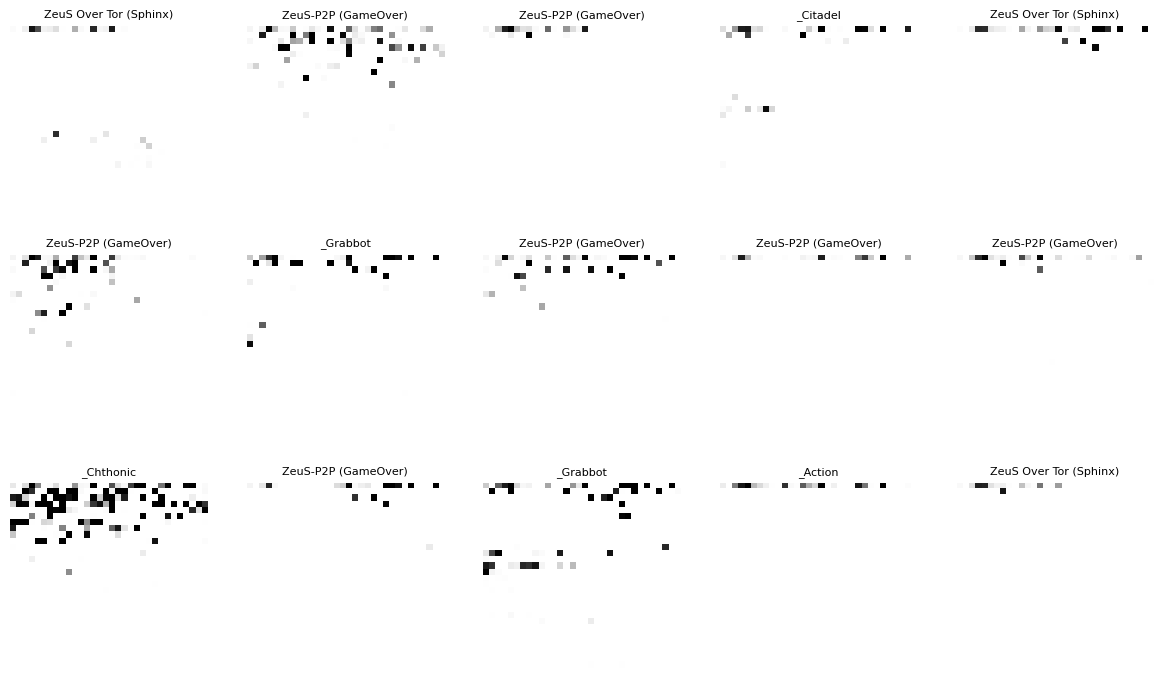



Guardados 15 JSON en ./Decoded_JSONs
Guardadas 15 imágenes PNG en ./Decoded_PNGs


In [33]:
from PIL import Image

# === Ajustes de salida ===
OUT_JSON_DIR = "./Decoded_JSONs"
OUT_IMG_DIR  = "./Decoded_PNGs"   # opcional
os.makedirs(OUT_JSON_DIR, exist_ok=True)
os.makedirs(OUT_IMG_DIR, exist_ok=True)

def save_img_png_from_minus1_1(img_minus1_1: np.ndarray, path: str):
    """
    Guarda una imagen (H,W) o (H,W,1) en rango [-1,1] como PNG en escala de grises.
    """
    if img_minus1_1.ndim == 3 and img_minus1_1.shape[-1] == 1:
        img_minus1_1 = img_minus1_1[..., 0]
    img01 = (img_minus1_1 + 1.0) / 2.0
    img255 = np.clip(img01 * 255.0, 0, 255).astype(np.uint8)
    Image.fromarray(img255, mode="L").save(path)

# === Mostrar en grid y decodificar ===
def show_and_decode_all(gen_imgs, cols=5, figsize=(12, 7)):
    """
    Muestra un grid con todas las imágenes de gen_imgs, decodifica cada una a JSON
    y guarda:
      - ./Decoded_JSONs/decoded_{i:04d}__{family}.json
      - ./Decoded_PNGs/img_{i:04d}.png  (opcional)
    """
    n = len(gen_imgs)
    if n == 0:
        print("No hay imágenes en gen_imgs.")
        return

    rows = (n + cols - 1) // cols
    fig, axs = plt.subplots(rows, cols, figsize=figsize)
    axs = np.atleast_2d(axs)

    cnt = 0
    for r in range(rows):
        for c in range(cols):
            ax = axs[r, c]
            if cnt < n:
                img = gen_imgs[cnt]  # rango [-1,1]
                # Mostrar
                ax.imshow(img.squeeze() if img.ndim==3 else img, cmap="gray_r", vmin=-1, vmax=1)
                ax.axis("off")

                # Decodificar
                vec01 = imagen_a_vector(img)     # [-1,1] -> [0,1] aplanado
                decoded = vector_a_json(vec01)   # JSON reconstruido

                # Título con familia
                fam = decoded["file_info"]["software_family"]
                ax.set_title(fam, fontsize=8)

                # Guardar JSON
                json_name = f"decoded_{cnt:04d}__{fam.replace(' ', '_')}.json"
                with open(os.path.join(OUT_JSON_DIR, json_name), "w", encoding="utf-8") as f:
                    json.dump(decoded, f, indent=2, ensure_ascii=False)

                # (Opcional) Guardar PNG
                png_name = f"img_{cnt:04d}.png"
                save_img_png_from_minus1_1(img, os.path.join(OUT_IMG_DIR, png_name))

                cnt += 1
            else:
                ax.axis("off")

    plt.tight_layout()
    plt.show()
    print(f"\n\nGuardados {n} JSON en {OUT_JSON_DIR}")
    print(f"Guardadas {n} imágenes PNG en {OUT_IMG_DIR}")

# === USO ===
# Llama esto tras generar tus imágenes de la GAN:
show_and_decode_all(gen_imgs, cols=5, figsize=(12, 7))